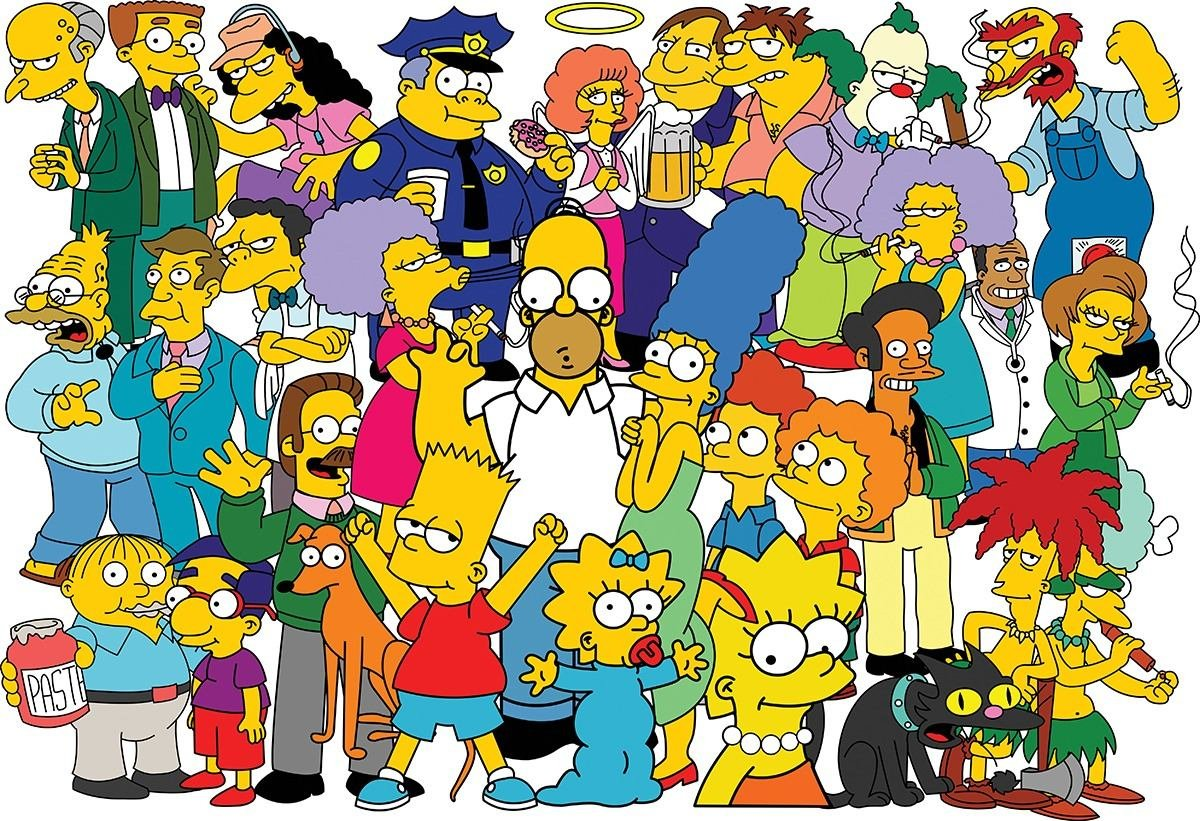

# Классификация изображений
## Описание проекта

Телекомпании FOX необходимо построить модель для обработки их контента. Сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989.

В данном проекте мне необходимо классифицировать персонажей, проживающих в Спрингфилде.


## Описание данных

Все необходимые данные для исследования содержатся в файле `journey-springfield.zip`, в котором имеется тренировочная выборка с размеченными данными и тестовая выборка без них.

Целевая метрика (f1-score) на тестовых данных будет определяться на платформе Kaggle.com.

## План работы



1.   Изучить датасет изображений, подготовить данные для дальнейшего обучения нейросети.
2.   Написать и реализовать собственную нейросеть, протестировать ее, достигнуть опредленной метрики.
3.   Реализовать нейросеть на основании уже преодобученных моделях. Сравнить метрики, полученные в п.2. и п. 3.
4. Выбрать итоговую модель.




## Установка зависимостей и библиотек

In [1]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
import PIL
from PIL import Image
from pathlib import Path

import torch
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms, models
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from collections import defaultdict
import seaborn as sns
from copy import deepcopy

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


# Изучение и подготовка данных

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Разархивируем архив и посмотрим внимательнее на данные.

In [4]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

Ниже мы используем враппер над датасетом для удобной работы.
Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.

Также используется LabelEncoder для преобразования строковых меток классов в id и обратно.

In [5]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            # Получение меток классов по именам папок, в которых находятся изображения.
            self.labels = [path.parent.name for path in self.files]
            # Обучение кодировщика меток на полученных метках.
            self.label_encoder.fit(self.labels)

            # Открытие файла для сохранения кодировщика меток.
            with open('label_encoder.pkl', 'wb') as le_dump_file:
            # Сохранение кодировщика меток в файл.
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        augmentation = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomRotation(25),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        x = self.load_sample(self.files[index])

        if self.mode == 'train':
          x = augmentation(x)
        else:
          x = transform(x)

        if self.mode == 'test':
            return x
        else:
            # Получение метки (названия класса) для данного изображения
            label = self.labels[index]
            # Кодирование метки в числовой формат
            label_id = self.label_encoder.transform([label])
            # Получение числового значения метки.
            y = label_id.item()
            return x, y

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    #  Преобразует тензор inp в массив NumPy и изменяет порядок измерений с (C, H, W) на (H, W, C). Это нужно для правильного отображения изображения.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #  Нормализация входного изображения с помощью средних значений и стандартных отклонений.
    inp = std * inp + mean
    #  Обрезка значений в массиве NumPy до диапазона от 0 до 1, чтобы гарантировать корректное отображение.
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [9]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

Давайте посмотрим на наших героев внутри датасета.

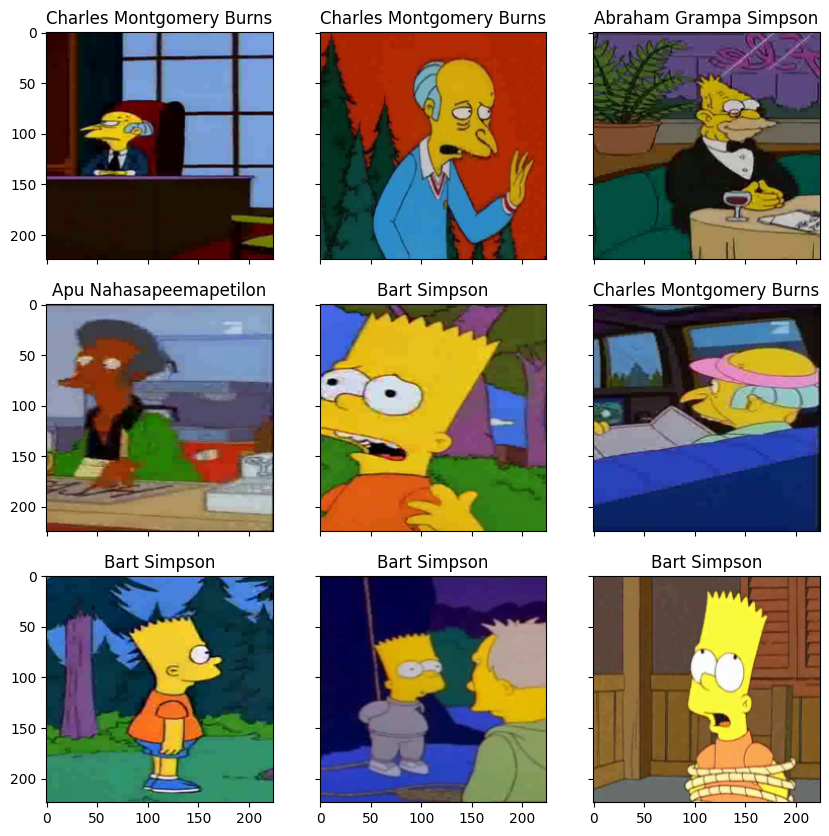

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Тепеоь посмотрим на распределение классов.

In [13]:
print('Количество персонажей в мультфильме:')
len(set(train_val_labels))

Количество персонажей в мультфильме:


42

In [14]:
character_counts = defaultdict(int)
for name in train_val_labels:
    character_counts[name] += 1

sorted_characters = sorted(character_counts, key=character_counts.get)

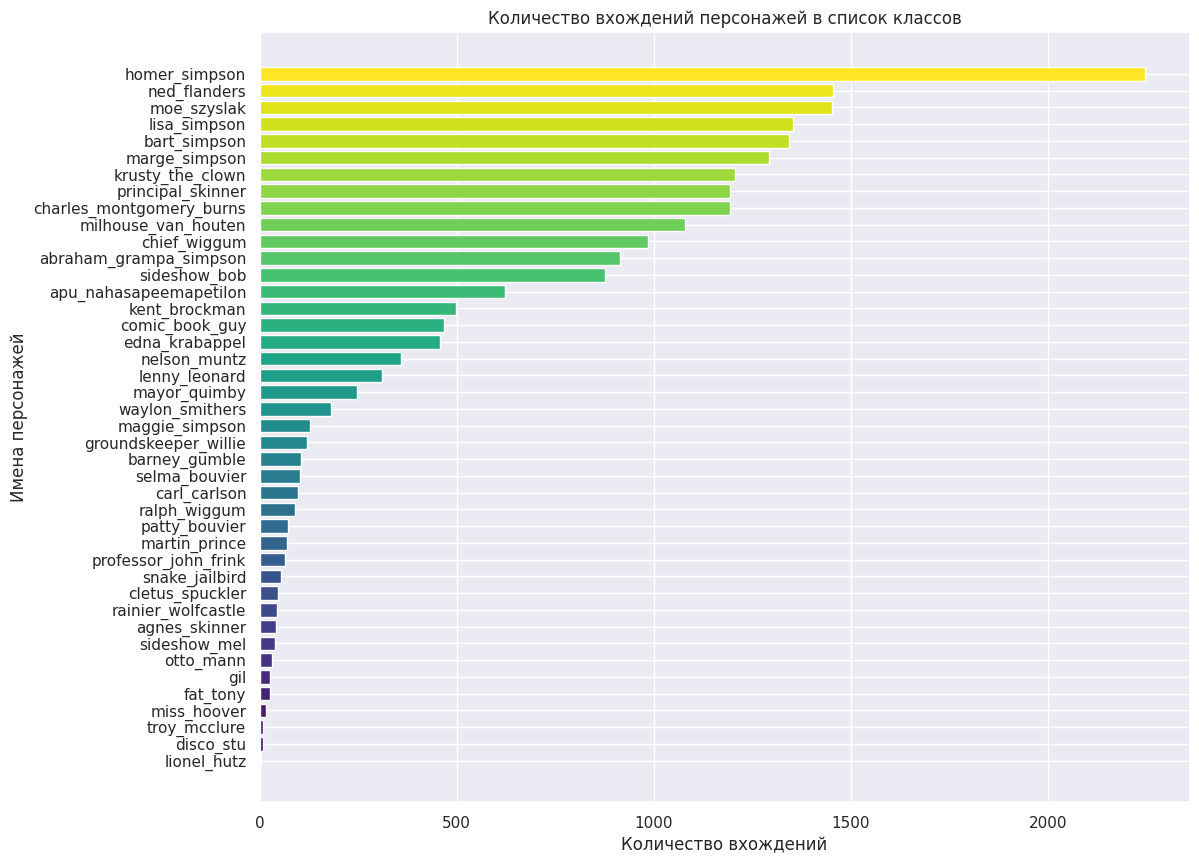

In [15]:
characters = [char for char in sorted_characters]
counts = [character_counts[char] for char in sorted_characters]
colors = plt.cm.viridis(np.linspace(0, 1, len(characters)))  # Генерируем разные цвета

# Создаем график
sns.set(rc={'figure.figsize': (12, 10)})
bars = plt.barh(characters, counts, color=colors)

# Добавляем заголовок и метки осей
plt.title('Количество вхождений персонажей в список классов')
plt.xlabel('Количество вхождений')
plt.ylabel('Имена персонажей')

# Отображаем график
plt.show()

Классы распределены очень неравномерно, что в дальнейшем может ухудшить точность нашей модели при классификации именно минорных классов.

# Построение простой сверточной нейросети

Для начала построим простую сверточную нейронную сеть и определим на ней целевую метрику.

*Описание слоев нейросети*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [16]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [17]:
def show_plots(history):

    train_loss, train_f1, val_loss, val_f1 = zip(*history)
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    axes[0].plot(np.arange(1, len(train_loss) + 1), train_loss, label="train_loss")
    axes[0].plot(np.arange(1, len(val_loss) + 1), val_loss, label="val_loss")
    best_epoch = np.argmin(val_loss) + 1
    axes[0].axvline(best_epoch, color='r', label="best epoch by loss")
    axes[0].legend(loc='best')
    axes[0].set_xlabel("epochs")
    axes[0].set_ylabel("loss")

    axes[1].plot(np.arange(1, len(train_f1) + 1), train_f1, label="train_f1")
    axes[1].plot(np.arange(1, len(val_f1) + 1),val_f1, label="val_f1")
    best_epoch = np.argmax(val_f1) + 1
    axes[1].axvline(best_epoch, color='r', label="best epoch by f1-score")
    axes[1].legend(loc='best')
    axes[1].set_xlabel("epochs")
    axes[1].set_ylabel("f1-score")

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = []
    running_f1 = []

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)

        running_loss.append(loss.item())
        running_f1.append(f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='micro'))

    train_loss = np.array(running_loss).mean()
    train_f1 = np.array(running_f1).mean()
    return train_loss, train_f1

In [19]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = []
    running_f1 = []

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss.append(loss.item())
        running_f1.append(f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='micro'))

    val_loss = np.array(running_loss).mean()
    val_f1 = np.array(running_f1).mean()
    return val_loss, val_f1

In [20]:
def train(train_files, val_files, model, epochs, batch_size, opt):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    best_model = None

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_f1 {t_f1:0.4f} val_f1 {v_f1:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_f1 = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_f1, val_loss, val_f1))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = deepcopy(model)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_f1=train_f1, v_f1=val_f1))

    show_plots(history)

    return best_model

In [21]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [22]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=0.001)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.5895659094903527


epoch:   5%|▌         | 1/20 [01:53<35:50, 113.16s/it]


Epoch 001 train_loss: 2.5896     val_loss 1.9661 train_f1 0.2802 val_f1 0.4647
loss 1.6096302796670092


epoch:  10%|█         | 2/20 [03:42<33:12, 110.71s/it]


Epoch 002 train_loss: 1.6096     val_loss 1.3540 train_f1 0.5617 val_f1 0.6260
loss 1.1617822942694997


epoch:  15%|█▌        | 3/20 [05:31<31:13, 110.22s/it]


Epoch 003 train_loss: 1.1618     val_loss 1.0260 train_f1 0.6854 val_f1 0.7225
loss 0.9242794382862929


epoch:  20%|██        | 4/20 [07:20<29:15, 109.71s/it]


Epoch 004 train_loss: 0.9243     val_loss 0.9039 train_f1 0.7448 val_f1 0.7595
loss 0.7823503036809162


epoch:  25%|██▌       | 5/20 [09:03<26:47, 107.16s/it]


Epoch 005 train_loss: 0.7824     val_loss 0.8139 train_f1 0.7863 val_f1 0.7887
loss 0.6761572465179412


epoch:  30%|███       | 6/20 [10:46<24:40, 105.72s/it]


Epoch 006 train_loss: 0.6762     val_loss 0.7281 train_f1 0.8134 val_f1 0.8113
loss 0.589270202124991


epoch:  35%|███▌      | 7/20 [12:28<22:38, 104.50s/it]


Epoch 007 train_loss: 0.5893     val_loss 0.7558 train_f1 0.8334 val_f1 0.8060
loss 0.5246241139323731


epoch:  40%|████      | 8/20 [14:11<20:48, 104.05s/it]


Epoch 008 train_loss: 0.5246     val_loss 0.6771 train_f1 0.8520 val_f1 0.8269
loss 0.4706051276345563


epoch:  45%|████▌     | 9/20 [15:53<18:57, 103.39s/it]


Epoch 009 train_loss: 0.4706     val_loss 0.6556 train_f1 0.8644 val_f1 0.8337
loss 0.4210817103342312


epoch:  50%|█████     | 10/20 [17:35<17:11, 103.16s/it]


Epoch 010 train_loss: 0.4211     val_loss 0.6499 train_f1 0.8818 val_f1 0.8404
loss 0.40628160342452974


epoch:  55%|█████▌    | 11/20 [19:17<15:23, 102.66s/it]


Epoch 011 train_loss: 0.4063     val_loss 0.6143 train_f1 0.8847 val_f1 0.8512
loss 0.3588477551513086


epoch:  60%|██████    | 12/20 [21:01<13:43, 102.98s/it]


Epoch 012 train_loss: 0.3588     val_loss 0.6284 train_f1 0.8997 val_f1 0.8529
loss 0.33581782347424244


epoch:  65%|██████▌   | 13/20 [22:42<11:57, 102.54s/it]


Epoch 013 train_loss: 0.3358     val_loss 0.6622 train_f1 0.9019 val_f1 0.8417
loss 0.31899581955579237


epoch:  70%|███████   | 14/20 [24:25<10:15, 102.65s/it]


Epoch 014 train_loss: 0.3190     val_loss 0.6078 train_f1 0.9062 val_f1 0.8561
loss 0.2948344232650792


epoch:  75%|███████▌  | 15/20 [26:09<08:34, 102.93s/it]


Epoch 015 train_loss: 0.2948     val_loss 0.6254 train_f1 0.9120 val_f1 0.8602
loss 0.28922337841818


epoch:  80%|████████  | 16/20 [27:52<06:52, 103.14s/it]


Epoch 016 train_loss: 0.2892     val_loss 0.6020 train_f1 0.9151 val_f1 0.8622
loss 0.27178567263290165


epoch:  85%|████████▌ | 17/20 [29:35<05:08, 102.98s/it]


Epoch 017 train_loss: 0.2718     val_loss 0.6129 train_f1 0.9210 val_f1 0.8633
loss 0.2550357437382142


epoch:  90%|█████████ | 18/20 [31:19<03:26, 103.45s/it]


Epoch 018 train_loss: 0.2550     val_loss 0.6414 train_f1 0.9243 val_f1 0.8594
loss 0.25053847743183133


epoch:  95%|█████████▌| 19/20 [33:05<01:44, 104.10s/it]


Epoch 019 train_loss: 0.2505     val_loss 0.6362 train_f1 0.9274 val_f1 0.8594
loss 0.2284279642853795


epoch: 100%|██████████| 20/20 [34:47<00:00, 104.37s/it]



Epoch 020 train_loss: 0.2284     val_loss 0.6864 train_f1 0.9305 val_f1 0.8632


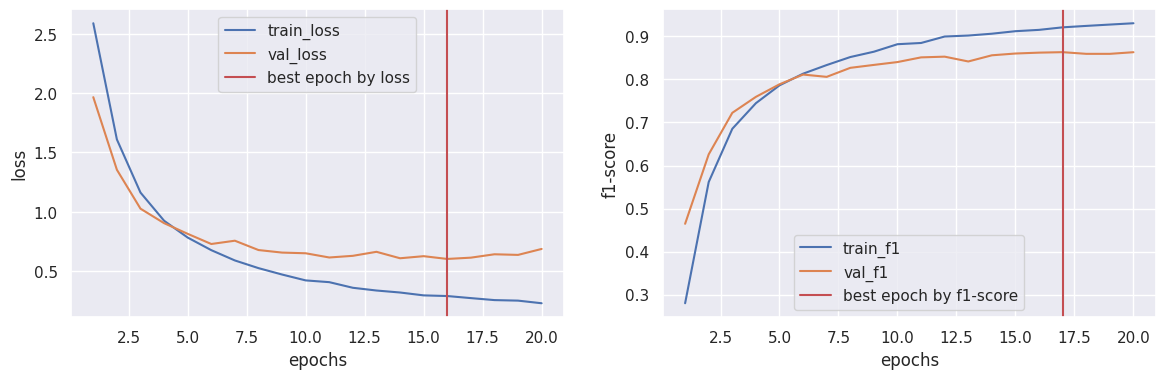

In [23]:
simple_cnn = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=64, opt=optimizer)

Как видно, модель переучивается, и максимальное значение метрики, которое ей удалость достичь, - 0.8619 на валидационном датасете.

Сделаем визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах.

In [24]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [25]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

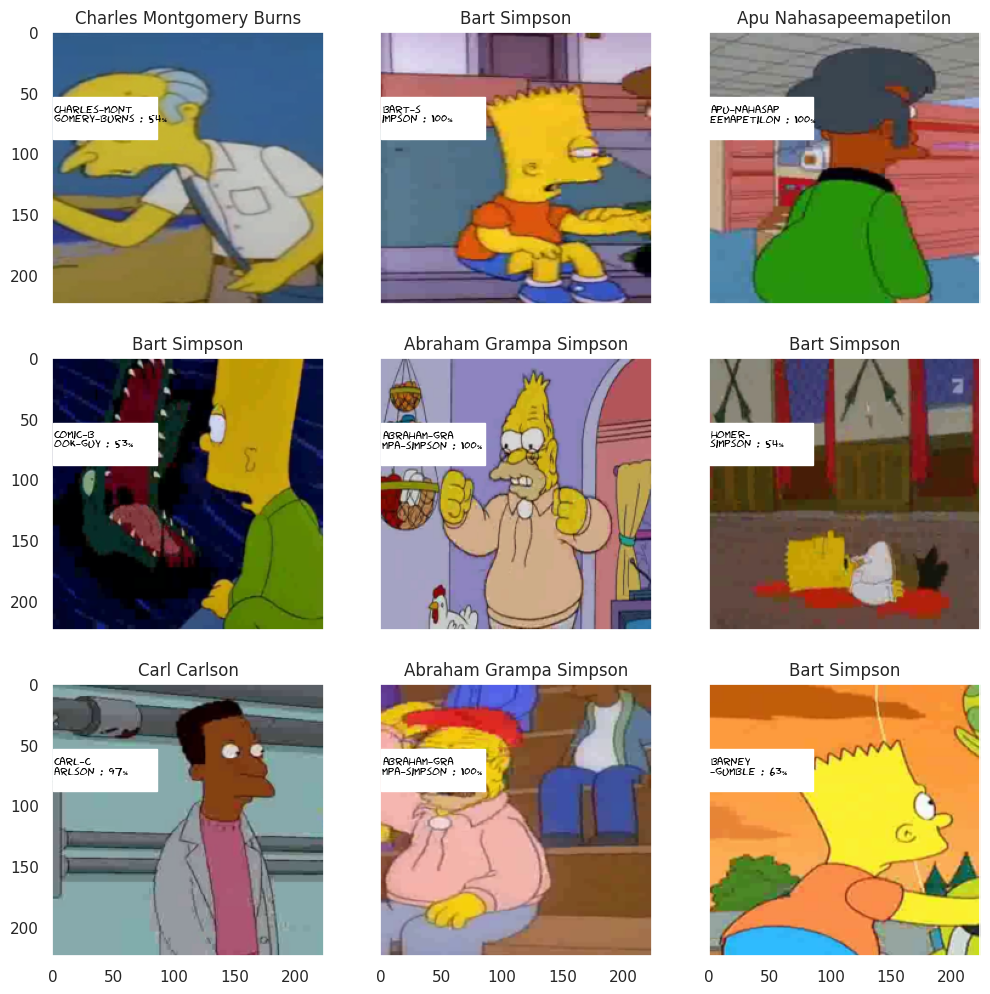

In [26]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Нейросети на основе предобученных моделей

Используем для построение архитекутры сети уже преобученные модели из библиотеки torchvision.models.

## Модель Resnet34

In [33]:
model_34 = models.resnet34(pretrained=True)
in_features = model_34.fc.in_features
# Заменяем Fully-Connected слой на наш линейный классификатор
model_34.fc = nn.Linear(in_features, n_classes)
model_34 = model_34.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 0.7482205730507044


epoch:  14%|█▍        | 1/7 [02:56<17:39, 176.56s/it]


Epoch 001 train_loss: 0.7482     val_loss 0.2464 train_f1 0.8276 val_f1 0.9434
loss 0.32232418592746664


epoch:  29%|██▊       | 2/7 [05:48<14:28, 173.65s/it]


Epoch 002 train_loss: 0.3223     val_loss 0.2394 train_f1 0.9153 val_f1 0.9430
loss 0.19638058341040118


epoch:  43%|████▎     | 3/7 [08:40<11:31, 172.86s/it]


Epoch 003 train_loss: 0.1964     val_loss 0.2234 train_f1 0.9491 val_f1 0.9406
loss 0.14588078560602918


epoch:  57%|█████▋    | 4/7 [11:32<08:38, 172.70s/it]


Epoch 004 train_loss: 0.1459     val_loss 0.2042 train_f1 0.9597 val_f1 0.9441
loss 0.11878396030629008


epoch:  71%|███████▏  | 5/7 [14:25<05:45, 172.68s/it]


Epoch 005 train_loss: 0.1188     val_loss 0.1654 train_f1 0.9680 val_f1 0.9591
loss 0.05143318460105229


epoch:  86%|████████▌ | 6/7 [17:16<02:52, 172.29s/it]


Epoch 006 train_loss: 0.0514     val_loss 0.1254 train_f1 0.9857 val_f1 0.9728
loss 0.03847671533606822


epoch: 100%|██████████| 7/7 [20:07<00:00, 172.56s/it]



Epoch 007 train_loss: 0.0385     val_loss 0.1208 train_f1 0.9898 val_f1 0.9714


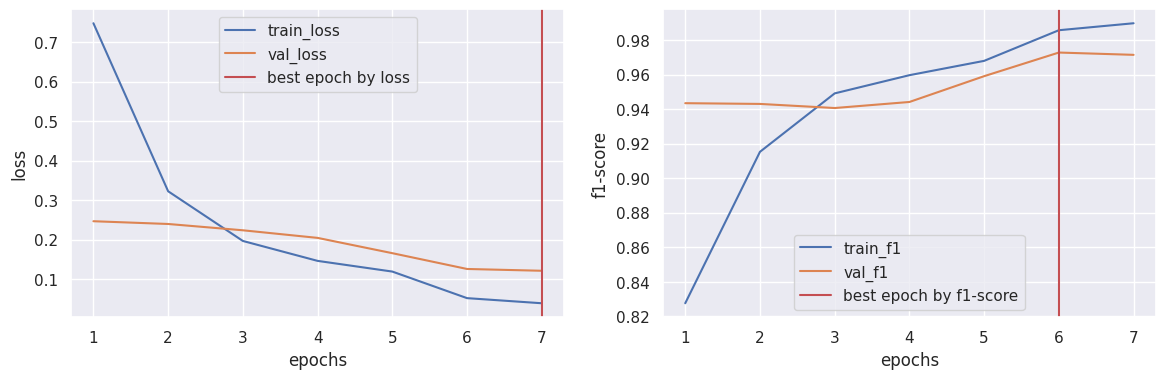

In [34]:
optimizer = torch.optim.Adam(model_34.parameters(), lr=0.0001)
model_34 = train(train_dataset, val_dataset, model=model_34, epochs=7, batch_size=64, opt=optimizer)

Модель достигает высокой метрики 0,9728 на шестой эпохе.

## Модель Resnet50

Попрробуем еще 1 вариант из предобученных моделей, а также немного изменим функцию train, добавим scheduler.

In [29]:
def train(train_files, val_files, model, epochs, batch_size, opt):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    best_model = None

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_f1 {t_f1:0.4f} val_f1 {v_f1:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()
        scheduler = lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)

        for epoch in range(epochs):
            train_loss, train_f1 = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_f1, val_loss, val_f1))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = deepcopy(model)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_f1=train_f1, v_f1=val_f1))
            scheduler.step()

    show_plots(history)

    return best_model

In [30]:
model_50 = models.resnet50(pretrained=True)
in_features = model_50.fc.in_features
# Заменяем Fully-Connected слой на наш линейный классификатор
model_50.fc = nn.Linear(in_features, n_classes)
model_50 = model_50.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


In [31]:
layers_to_unfreeze = 50
for parameter in list(model_50.parameters())[:-layers_to_unfreeze]:
    parameter.requires_grad = False

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.7197241869156923


epoch:  10%|█         | 1/10 [02:52<25:55, 172.83s/it]


Epoch 001 train_loss: 0.7197     val_loss 0.4369 train_f1 0.8231 val_f1 0.8915
loss 0.5005334189267663


epoch:  20%|██        | 2/10 [05:46<23:05, 173.23s/it]


Epoch 002 train_loss: 0.5005     val_loss 0.3318 train_f1 0.8740 val_f1 0.9202
loss 0.2859542181912234


epoch:  30%|███       | 3/10 [08:38<20:10, 172.91s/it]


Epoch 003 train_loss: 0.2860     val_loss 0.3023 train_f1 0.9268 val_f1 0.9243
loss 0.22083975154361346


epoch:  40%|████      | 4/10 [11:31<17:17, 172.94s/it]


Epoch 004 train_loss: 0.2208     val_loss 0.3362 train_f1 0.9415 val_f1 0.9268
loss 0.20020284050908999


epoch:  50%|█████     | 5/10 [14:24<14:23, 172.69s/it]


Epoch 005 train_loss: 0.2002     val_loss 0.2579 train_f1 0.9488 val_f1 0.9345
loss 0.09951158335249742


epoch:  60%|██████    | 6/10 [17:17<11:32, 173.09s/it]


Epoch 006 train_loss: 0.0995     val_loss 0.1645 train_f1 0.9753 val_f1 0.9645
loss 0.07475246097636977


epoch:  70%|███████   | 7/10 [20:10<08:38, 172.92s/it]


Epoch 007 train_loss: 0.0748     val_loss 0.1912 train_f1 0.9808 val_f1 0.9584
loss 0.06840343784556982


epoch:  80%|████████  | 8/10 [23:02<05:45, 172.70s/it]


Epoch 008 train_loss: 0.0684     val_loss 0.1641 train_f1 0.9814 val_f1 0.9632
loss 0.05959365519077888


epoch:  90%|█████████ | 9/10 [25:57<02:53, 173.23s/it]


Epoch 009 train_loss: 0.0596     val_loss 0.1774 train_f1 0.9831 val_f1 0.9596
loss 0.0635822300573932


epoch: 100%|██████████| 10/10 [28:58<00:00, 173.90s/it]



Epoch 010 train_loss: 0.0636     val_loss 0.2018 train_f1 0.9831 val_f1 0.9568


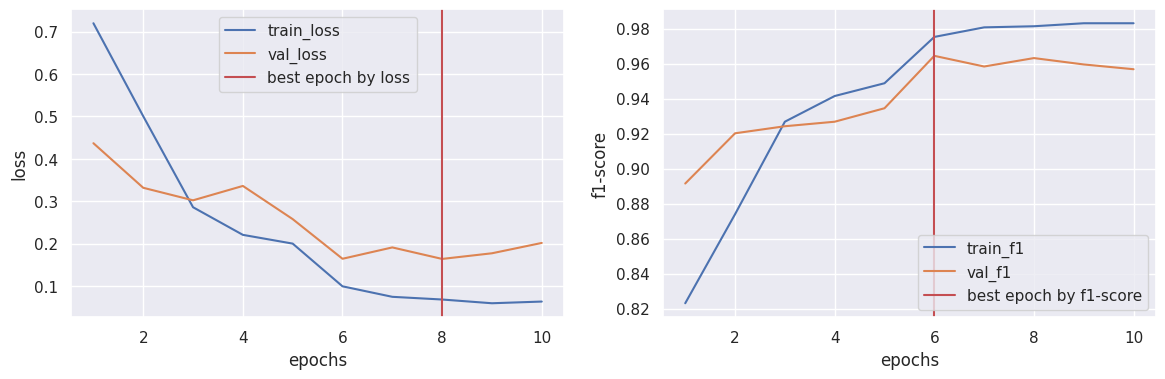

In [32]:
optimizer = torch.optim.Adam(list(model_50.parameters())[-layers_to_unfreeze:], lr=0.001)
model_50 = train(train_dataset, val_dataset, model=model_50, epochs=10, batch_size=64, opt=optimizer)

# Выводы по проделанной работе

В рамках данного проекта стояла задача - построить модель по классификации персонажей их мультсериала "Simpsons".

В  течение проекта были предприняты следующие шаги:
1. были загружены и пронализированы имеющиеся изображения.
2. были построены 3 модели нейросетей: 1 простая сверточная нейронная сетьи и 2 модели, основаннные на уже предобученных моделях Resnet-34 и Resnet-50.

В итоге лучшим вариантом оказалась модель на основе Resnet-34, которая показала минимальную ошибку на валидационном наборе данных, с целевой метрикой в 0,9728.